In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.path.abspath(''), '..')))

import math
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import pandas as pd
import hydracv.utils.utils as utils
from classifier.classifier import Classifier
from scipy import stats as st

In [3]:
EXP_NAME = 'GCaMP6_Bisection_Exp6'# TO MODIFY
VIDEO_NAME = "71420_ngcamp_hy6_peduncle48hr" # TO MODIFY
BODY_PART = "/Peduncle/" # TO MODIFY

BISECTION_DATA_HOME = "/Users/katyabrooun/Google Drive/Shared drives/hydra/data-analysis/Bisection_Full/"
SAVE_DIR = '/Users/katyabrooun/Fairhall_Lab/hydra/bisection-data-analysis/exp6' + BODY_PART
FILE_FLUO = SAVE_DIR + 'total_fluo_' + VIDEO_NAME + '.csv'
FILE_LENGTH = SAVE_DIR + "lengths_" + VIDEO_NAME + ".csv"
FILE_MIDPOINTS = SAVE_DIR + "midpoints_"+ VIDEO_NAME +".csv"
FILE_VIDEO = BISECTION_DATA_HOME + "Original_Videos/" + EXP_NAME + BODY_PART + VIDEO_NAME + ".avi"

SAVE_DIR = BISECTION_DATA_HOME + "Contraction_Analysis/"

FPS = 5 # TO MODIFY

## Load Fluorescence and Length

In [4]:
# Load fluorescence
fluo = pd.read_csv(FILE_FLUO).values.reshape(-1)

In [5]:
# Load the length
length = pd.read_csv(FILE_LENGTH).values.reshape(-1)

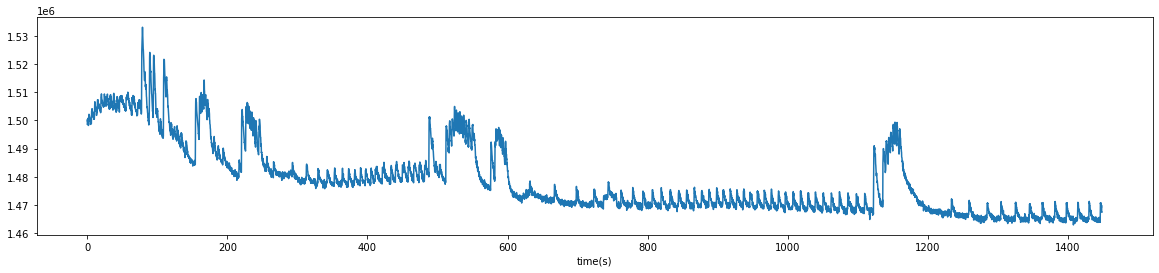

In [6]:
# Plot the fluorescence (x axis is real time)
min_length = min(len(fluo), len(length))

x_time = np.arange(0, min_length/FPS, 1/FPS)
x_frame = np.arange(0, min_length,1)
plt.figure(figsize=(20,4))
plt.plot(x_time, fluo)
plt.xlabel('time(s)')
plt.show()

### Clean up fluo timeseries

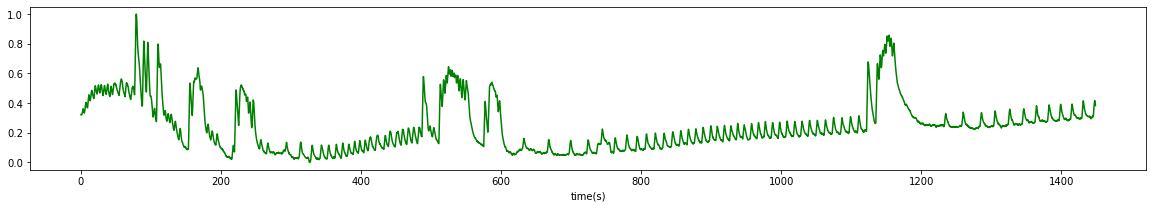

In [7]:
# DO NOT CHANGE KERNEL SIZE FOR SMOOTHING FLUO
fluo = utils.smooth_timeseries(fluo, 10)
fluo = utils.remove_trend_fluo(fluo)

# once we remove trend, fluo no longer reflects absolute a.u. values
fluo = utils.normalize(fluo)

plt.figure(figsize=(20,3))
plt.plot(x_time,fluo,color='g')
plt.xlabel('time(s)')
plt.show()

### Clean up length timeseries

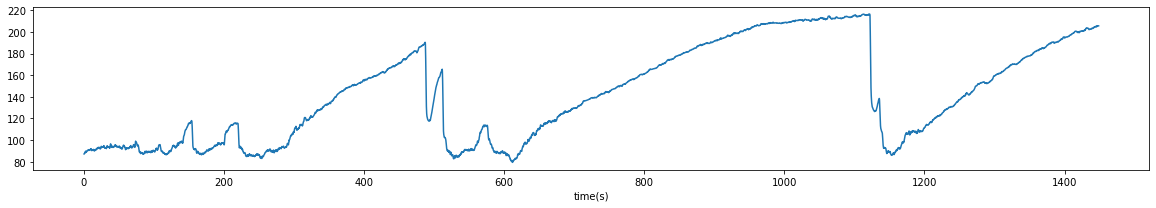

In [8]:
length = utils.smooth_timeseries(length, 5)
plt.figure(figsize=(20,3))
plt.plot(x_time,length)
plt.xlabel('time(s)')
plt.show()

## Identify Periods of Contraction

In [9]:
# Create object
classifier = Classifier()
classifier.set_midpoints(FILE_MIDPOINTS,
                         winlen_len=51)
classifier.set_videopath(FILE_VIDEO)

Calculating curvature...


100%|██████████| 7244/7244 [00:46<00:00, 157.06it/s]


Curvature set.


In [34]:
# Run the classifier

# Parameters:
# winlen_slp: window-length for smoothing slope, larger value == smoother slope curve
# lo_slp_thres: higher bound of slope in predicting contraction, larger value == more sensitive to contraction
# hi_slp_thres: lower bound of slope in predicting elongation, smaller value == more sensitive to elongation
# lo_len_thres: higher bound of length in predicting CB, larger value == looser restriction to predict CB
    # normalized length
# hi_len_thres: lower bound of length in predicting an elongated state, smaller value == looser restriction to predict elongated
# curv_thres: threshold of curvature to identify a bending behavior
# cb_no_elong: whether to deny the "bounding backs" during CB as elongation? True == Yes


classifier.classify_behavior(winlen_slp=101,
                    lo_slp_thres=0,
                    lo_len_thres=0.2,
                    cb_no_elong=False,
                    elong_no_cb=True)

In [35]:
behavior = classifier.behaviors
contraction = np.zeros(classifier.nframes)

for i in range(len(contraction)):
    if behavior[i][0] == 'Contraction':
        contraction[i] = 1

In [36]:
def plot_fluo_len(ax, fluo, length):
    ax_ = ax.twinx()
    lns1 = ax.plot(length, 'b', label='length')
    lns2 = ax.plot(fluo, 'g', label='fluo')

    lns = lns1 + lns2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc='best')
    ax.set(xlabel='Frame #', ylabel='Length/ fluo (normalized)', title=VIDEO_NAME)

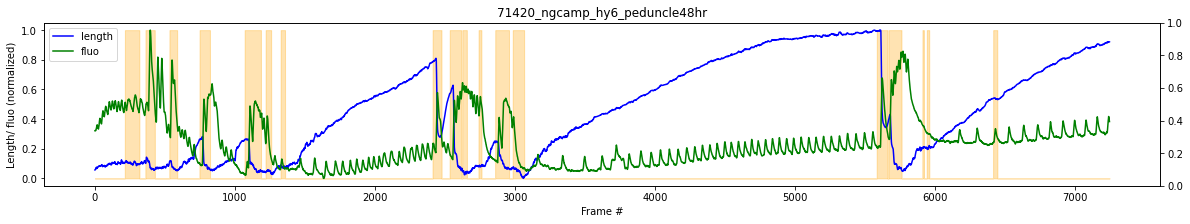

In [37]:
# Plot periods of contraction
x = np.arange(0,min_length,1)
y = contraction

length_norm = utils.normalize(length)

fig = plt.figure(figsize=(20,3))
ax = fig.add_subplot(1,1,1)
plot_fluo_len(ax,fluo,length_norm)
ax.fill_between(x, y, color='orange', alpha=0.3)
plt.show()

In [32]:
classifier.cb_bounds = []
classifier.classify_neural_activity(cb_combine=50, min_cb_size=50)
df = pd.DataFrame(classifier.cb_bounds)
df.to_csv(SAVE_DIR + VIDEO_NAME + "_cb_bounds.csv")

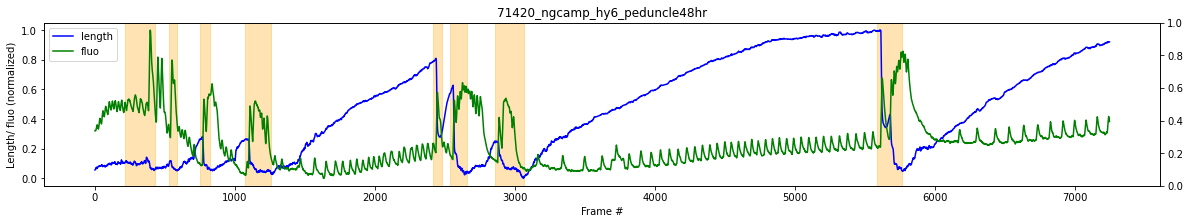

In [33]:
# Plot CB events
cb_bounds = pd.read_csv(SAVE_DIR + VIDEO_NAME + "_cb_bounds.csv")

fig = plt.figure(figsize=(20,3))
ax = fig.add_subplot(1,1,1)
plot_fluo_len(ax,fluo,length_norm)

it = iter(classifier.cb_bounds)
for x in it:
    ax.axvspan(x, next(it), color='orange', alpha=0.3)

## Find peaks during contraction

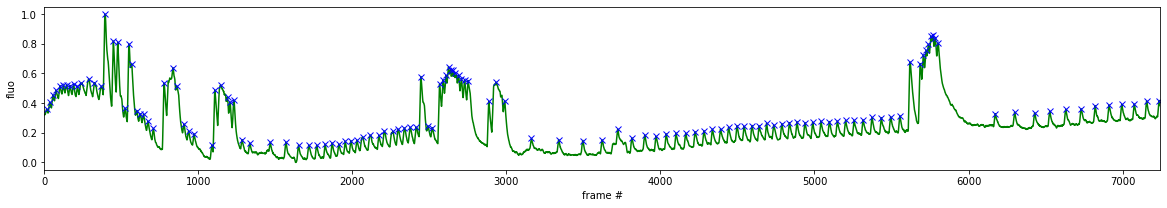

In [16]:
# DO NOT CHANGE THESE PARAMS
peaks_index = utils.find_peaks(fluo, height=None, wlen=50, prominence=0.02, realign=True, start=0, end=-1)

In [17]:
# Filter out peaks that happen during elongation

# Boolean array representing whether a CB event is occurring during a given frame
cb = np.zeros(classifier.nframes)
it = iter(classifier.cb_bounds)
for x in it:
    for i in range(x,next(it)):
        cb[i] = 1
        
cb_peaks = []

for i in peaks_index:
    if cb[i] == 1:
        cb_peaks.append(i)

cb_peaks = np.array(cb_peaks)

In [18]:
# Remove peaks that are part of incomplete CB events (cut off either at the beginning or the end of the time series)
start = 0 # EDIT
end = len(cb_peaks) #EDIT
cb_peaks = cb_peaks[start:end]

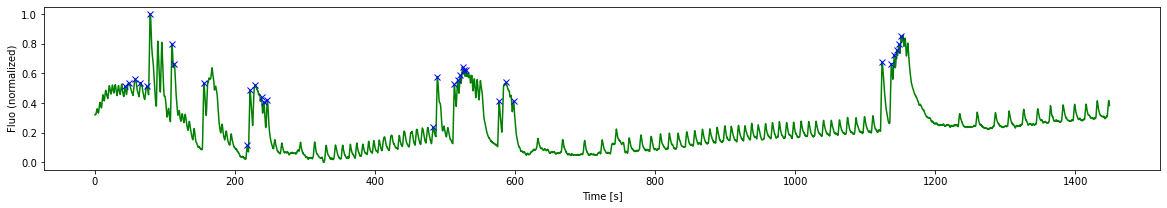

In [19]:
fig = plt.figure(figsize=(20, 3))
ax = fig.add_subplot(1, 1, 1)
utils.disp.add_fluorescence(ax, x_time, fluo, "Time [s]", "Fluo (normalized)")
utils.disp.add_peaks(ax, cb_peaks, fluo, fps=5)
plt.show()

In [20]:
# Organize peaks into CB events

boolean_peaks = np.zeros(len(cb))
for i in cb_peaks:
    boolean_peaks[i] = 1

cluster_ids = []
cluster_num = -1
prev_cb = False
for i in range(len(cb)):
    if boolean_peaks[i] == 1 and prev_cb:
        cluster_ids.append(cluster_num)
    elif boolean_peaks[i] == 1 and not prev_cb:
        cluster_num += 1
        cluster_ids.append(cluster_num)
        prev_cb = True
    elif cb[i] == 0:
        prev_cb = False

cluster_ids = np.array(cluster_ids)

In [21]:
clustered_peaks = np.vstack((cb_peaks, cluster_ids)).T

df = pd.DataFrame(clustered_peaks, columns=("Frame", "Cluster Id"))

In [22]:
df.to_csv(SAVE_DIR + VIDEO_NAME + "_cb_spikes.csv")

## Stats for contraction events

In [23]:
spikes = pd.read_csv(SAVE_DIR + VIDEO_NAME + "_cb_spikes.csv")

In [24]:
cluster_sizes = spikes.groupby(by="Cluster Id").count()["Frame"]

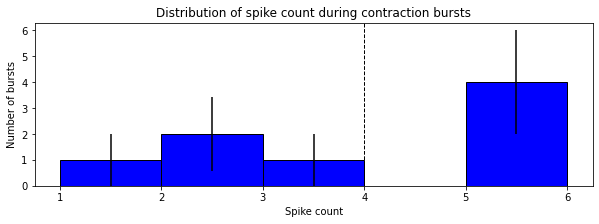

In [25]:
fig = plt.figure(figsize=(10, 3))
ax = fig.add_subplot(1, 1, 1)

y,binEdges = np.histogram(cluster_sizes, bins=5)
bin_width = binEdges[1]-binEdges[0]
bincenters = 0.5 * (binEdges[1:]+binEdges[:-1])
menStd = np.sqrt(y)
plt.bar(bincenters, y, width=bin_width, edgecolor='black', color='b', yerr=menStd)
plt.axvline(np.mean(cluster_sizes), color='k', linestyle='dashed', linewidth=1)
ax.set(title='Distribution of spike count during contraction bursts', xlabel="Spike count", ylabel="Number of bursts")
plt.show()

In [26]:
# Create 95% confidence interval for mean number of spikes per cluster. Using t distribution because n < 30
st.t.interval(alpha=0.95, df=len(cluster_sizes)-1, loc=np.mean(cluster_sizes), scale=st.sem(cluster_sizes))

(2.1574996276030394, 5.842500372396961)

## Comparison Across Videos